In [28]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

import pickle as pkl
import torch
import numpy as np

import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)
matplotlib.rcParams['font.size'] = 18
import matplotlib.pyplot as plt

In [18]:
As = [0,30,60,90,120,150]
Cs = [12.5,25,100]
vines = {}
for C in Cs:
    for A in As:
        with open(f'/home/nina/CopulaGP/out/Thy171_aligned_C{C}_A{A}_vine.pkl',"rb") as f:
            vines[f"{C}_{A}"] = pkl.load(f)

In [19]:
orders = {}
for C in Cs:
    for A in As:
        with open(f'/home/nina/CopulaGP/out/Thy171_aligned_C{C}_A{A}_trained.pkl',"rb") as f:
            trained = pkl.load(f)
        orders[f"{C}_{A}"] = trained['order']

In [4]:
collection = {k[0]:[] for k in Data['recs'][0]}

NameError: name 'Data' is not defined

In [53]:
device='cuda:0' # can be cuda, but no need for this here

a_N, c_N = 0,2
C = Cs[c_N]
A = As[a_N]

with open(f'/home/nina/CopulaGP/datasets/Thy171_aligned_C{C}_A{A}_layer0.pkl',"rb") as f:
    data = pkl.load(f)
trial_mask = data['trial_mask']

with open(f'/home/nina/CopulaGP/datasets/Thy171_all_aligned_C{C}_A{A}_layer0.pkl',"rb") as f:
    data = pkl.load(f)

X = data['X'][:131] # contains repetitions of the same 131 values
assert (X[0]==0.) & (X[-1]==1.) # easy sanity check, that ends are [0,1]
inputs = torch.tensor(X, device=device).float()

min, max = data['Y_preord'].min(axis=0), data['Y_preord'].max(axis=0)
Y = np.clip((data['Y_preord'] - min)/(max-min)*0.998+0.001,0.001,0.999)


In [54]:
Train = np.arange(180)[orders["100_0"]]
Test  = np.arange(180)[orders["100_30"]]
re_order = np.argsort(orders["100_30"])[orders["100_0"]]
np.all(Test[re_order]==Train)

True

In [55]:
lls = np.zeros([3,6,*Y.reshape(-1,131,180).shape[:2]])
for j,mod_C in enumerate(Cs):
    for i,mod_A in enumerate(As):
        trained_on = f"{mod_C}_{mod_A}"
        re_order = orders[trained_on]
        test_Y = torch.tensor(Y[...,re_order].reshape(-1,131,180), device=device).float()
        lls[j,i] = vines[trained_on].log_prob(test_Y).cpu().numpy()

In [56]:
lik = np.exp(lls)
posterior = lik/lik.sum(0).sum(0)

In [57]:
train_mask = trial_mask[data['trial_mask']]

In [58]:
# train_pred = mean_resp.sum(1).argmax(0)[train_mask==True]
# train_score = (train_pred==c_N).sum()/len(train_pred)
# test_pred = mean_resp.sum(1).argmax(0)[train_mask==False]
# test_score = (test_pred==c_N).sum()/len(test_pred)
# print(train_score,test_score)

In [59]:

mean_resp = posterior[...,33:99].mean(-1)
# assert np.all(mean_resp.mean(0).argmax(0)==a_N)
# assert np.all(mean_resp.mean(1).argmax(0)==c_N)
# mean_resp.sum(1).max(0)[train_mask]
np.array([mean_resp.sum(1).max(0)[train_mask==False],
mean_resp.sum(1).argmax(0)[train_mask==False]]).T

array([[0.37528899, 2.        ],
       [0.33376917, 2.        ],
       [0.34326927, 2.        ],
       [0.36161201, 2.        ],
       [0.35962663, 1.        ],
       [0.35694221, 2.        ],
       [0.36560486, 2.        ],
       [0.37532139, 2.        ],
       [0.35906983, 0.        ],
       [0.34026515, 2.        ],
       [0.34321937, 2.        ],
       [0.36493521, 2.        ],
       [0.34863801, 0.        ],
       [0.35560873, 2.        ],
       [0.37704407, 2.        ],
       [0.35721983, 2.        ]])

In [60]:
np.array([mean_resp.sum(1).max(0)[train_mask],
mean_resp.sum(1).argmax(0)[train_mask]]).T

array([[0.34571428, 2.        ],
       [0.3656266 , 2.        ],
       [0.54905861, 2.        ],
       [0.37731216, 2.        ],
       [0.47861907, 2.        ],
       [0.36613791, 2.        ]])

Text(0.5, 0, 'time, s')

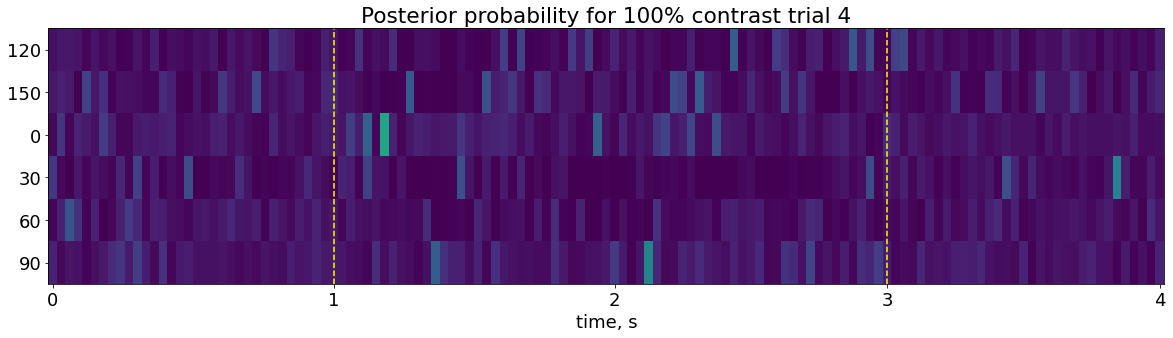

In [73]:
trial=4
plt.imshow(np.roll(posterior[2,:,trial,:],2-a_N,axis=0),aspect=5,interpolation='none',vmin=0,vmax=1)
plt.axvline(33,c='yellow',linestyle='dashed')
plt.axvline(98,c='yellow',linestyle='dashed')
plt.yticks([0,1,2,3,4,5],np.roll([0,30,60,90,120,150],2-a_N));
plt.title(f'Posterior probability for {C}% contrast trial {trial}')
plt.xticks([0,33,66,98,130],[0,1,2,3,4]);
plt.xlabel('time, s')

In [ ]:
trial = 9
plt.imshow(posterior[:,a_N,trial,:],aspect=5,interpolation='none',vmin=0,vmax=1)
plt.axvline(33,c='yellow',linestyle='dashed')
plt.axvline(98,c='yellow',linestyle='dashed')
plt.yticks([0,1,2],Cs);
plt.title(f'Posterior probability for {A}deg contrast trial {trial}')
plt.xticks([0,33,66,98,130],[0,1,2,3,4]);
plt.xlabel('time, s')

In [339]:
np.where(data['trial_mask'])

(array([0, 0, 1, 4, 4, 7]), array([14, 19, 11, 10, 17,  3]))

TypeError: Invalid shape (0,) for image data

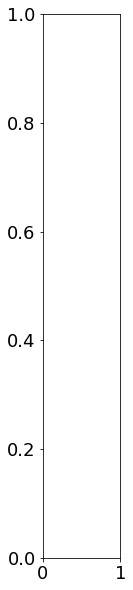

In [309]:
plt.imshow(np.roll(np.array(collection['A_29_1']),5,axis=-1),aspect=7,interpolation='none',vmin=0,vmax=1)
plt.axvline(33,c='yellow',linestyle='dashed')
plt.axvline(98,c='yellow',linestyle='dashed')

In [564]:
del(x)
f = lambda x: (x)**3#-0.001
fp = lambda x: 10*(x)**2

ValueError: operands could not be broadcast together with shapes (500,) (3,) 

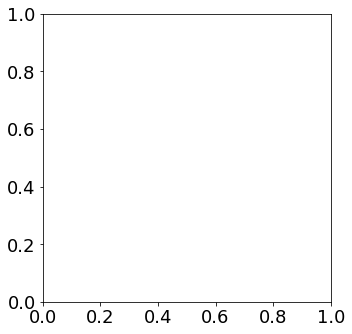

In [731]:
fig = plt.figure(figsize=(5,5))
ax_nonlin = fig.add_axes([0.2,0.2,0.8,0.8])

x = np.linspace(0,1,500)
ax_nonlin.plot(x,np.clip(f(x),0,np.inf))
ax_nonlin.set_xticks([])
ax_nonlin.set_yticks([])

locs = [0.3,0.6,0.9]

ax_u = fig.add_axes([0.2,0,0.8,0.2])
ax_u.axis('off')
ax_u.plot(x,1-np.exp(-(x-locs[0])**2/0.0009))
ax_u.plot(x,1-np.exp(-(x-locs[1])**2/0.0006))
ax_u.plot(x,1-np.exp(-(x-locs[2])**2/0.0003))

x = np.linspace(f(0),f(1),500)

ax_r = fig.add_axes([0,0.2,0.2,0.8])
ax_r.axis('off')
ax_r.plot(1-np.exp(-(x-f(locs[0]))**2/0.0009/fp(locs[0])),x)
ax_r.plot(1-np.exp(-(x-f(locs[1]))**2/0.0006/fp(locs[1])),x)
ax_r.plot(1-np.exp(-(x-f(locs[2]))**2/0.0003/fp(locs[2])),x)


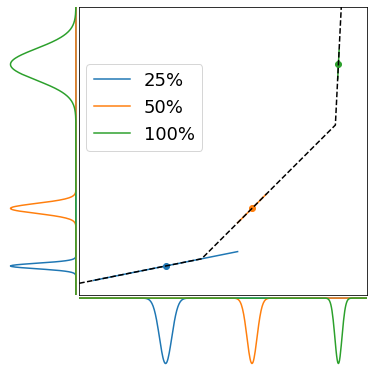

In [814]:
fig = plt.figure(figsize=(5,5))
ax_nonlin = fig.add_axes([0.2,0.2,0.8,0.8])

locs = [0.3,0.6,0.9]
tr_locs = [0.1,0.3,0.8]
tr_slope = [0.2,1.0,20.0]
vars = [0.0009,0.0006,0.0003]

for i in range(3):
    x = np.linspace(-0.05/tr_slope[i],+0.05/tr_slope[i],20)
    ax_nonlin.plot(locs[i]+x,tr_locs[i]+tr_slope[i]*x)
    ax_nonlin.scatter(locs[i],tr_locs[i])
ax_nonlin.set_xticks([])
ax_nonlin.set_yticks([])
ax_nonlin.set_xlim([0,1])
ax_nonlin.set_ylim([0,1])

x = np.linspace(0,1,500)

ax_u = fig.add_axes([0.2,0,0.8,0.2])
ax_u.axis('off')
ax_u.plot(x,1-np.exp(-(x-locs[0])**2/vars[0]))
ax_u.plot(x,1-np.exp(-(x-locs[1])**2/vars[1]))
ax_u.plot(x,1-np.exp(-(x-locs[2])**2/vars[2]))
ax_u.set_xlim([0,1])

ax_r = fig.add_axes([0,0.2,0.2,0.8])
ax_r.axis('off')
ax_r.plot(1-np.exp(-(x-tr_locs[0])**2/vars[0]/tr_slope[0]),x)
ax_r.plot(1-np.exp(-(x-tr_locs[1])**2/vars[1]/tr_slope[1]),x)
ax_r.plot(1-np.exp(-(x-tr_locs[2])**2/vars[2]/tr_slope[2]),x)
ax_r.set_ylim([0,1])

p1 = (tr_locs[1]-tr_locs[0]-locs[1]*tr_slope[1]+locs[0]*tr_slope[0])/(tr_slope[0]-tr_slope[1])
p2 = (tr_locs[2]-tr_locs[1]-locs[2]*tr_slope[2]+locs[1]*tr_slope[1])/(tr_slope[1]-tr_slope[2])
points_x = [0,p1,p2,1]
points_y = [tr_locs[0]+tr_slope[0]*(0-locs[0]),tr_locs[0]+tr_slope[0]*(p1-locs[0]),
           tr_locs[2]+tr_slope[2]*(p2-locs[2]),tr_locs[2]+tr_slope[2]*(1-locs[2])]
ax_nonlin.plot(points_x,points_y,c='k',linestyle='dashed')
plt.legend(["25%","50%","100%"],loc=(1.1,0.5))

In [713]:
n_p = 3
a = np.ones(n_p)
f = lambda x: np.sum(a*x**np.arange(n_p))
fp = lambda x: np.sum(np.arange(n_p-1)*a[1:]*x**np.arange(n_p-1))

In [714]:


def loss(a):
    f = lambda x: np.sum(a*x**np.arange(n_p))
    fp = lambda x: np.sum(np.arange(n_p-1)*a[1:]*x**np.arange(n_p-1))
    loss = 0
    for i in range(3):
        loss += 10*(f(locs[i])-tr_locs[i])**2
        loss += 0.5*(fp(locs[i])-tr_slope[i])**2
    loss += np.sum(a**2)
    return loss


In [715]:
from scipy.optimize import minimize
res = minimize(loss,np.ones(n_p))

(0.0, 1.0)

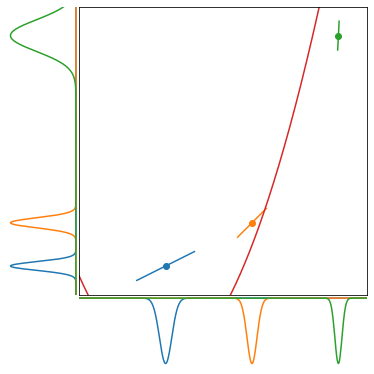

In [716]:
fig = plt.figure(figsize=(5,5))
ax_nonlin = fig.add_axes([0.2,0.2,0.8,0.8])


for i in range(3):
    x = np.linspace(-0.05/tr_slope[i],+0.05/tr_slope[i],20)
    ax_nonlin.plot(locs[i]+x,tr_locs[i]+tr_slope[i]*x)
    ax_nonlin.scatter(locs[i],tr_locs[i])
ax_nonlin.set_xticks([])
ax_nonlin.set_yticks([])
ax_nonlin.set_xlim([0,1])
ax_nonlin.set_ylim([0,1])

x = np.linspace(0,1,500)

# del(a)
f = lambda b: np.sum((res.x)*b**np.arange(n_p))
fv = np.vectorize(f)
ax_nonlin.plot(x,fv(x))

ax_u = fig.add_axes([0.2,0,0.8,0.2])
ax_u.axis('off')
ax_u.plot(x,1-np.exp(-(x-locs[0])**2/0.0009))
ax_u.plot(x,1-np.exp(-(x-locs[1])**2/0.0006))
ax_u.plot(x,1-np.exp(-(x-locs[2])**2/0.0003))
ax_u.set_xlim([0,1])

ax_r = fig.add_axes([0,0.2,0.2,0.8])
ax_r.axis('off')
ax_r.plot(1-np.exp(-(x-tr_locs[0])**2/0.0009/tr_slope[0]),x)
ax_r.plot(1-np.exp(-(x-tr_locs[1])**2/0.0006/tr_slope[1]),x)
ax_r.plot(1-np.exp(-(x-tr_locs[2])**2/0.0003/tr_slope[2]),x)
ax_r.set_ylim([0,1])

In [705]:
res.x.shape

(10,)

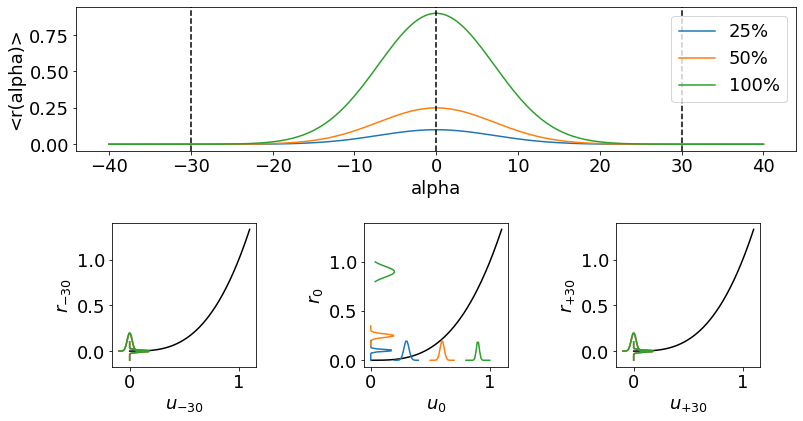

In [801]:
locs = [0.3,0.6,0.9]
tr_locs = [0.1,0.25,0.9]
tr_slope = [0.2,1.0,20.0]
vars = [0.0009,0.0006,0.0003]

fig = plt.figure(figsize=(10,5))
ax_tun = fig.add_axes([0,0.6,1,0.4])
ax_tr0 = fig.add_axes([0.4,0,0.2,0.4])
ax_trm = fig.add_axes([0.05,0,0.2,0.4])
ax_trp = fig.add_axes([0.75,0,0.2,0.4])

x = np.linspace(-40,+40,200)
ax_tun.plot(x,np.exp(-x**2/10**2)*tr_locs[0],label='25%')
ax_tun.plot(x,np.exp(-x**2/10**2)*tr_locs[1],label='50%')
ax_tun.plot(x,np.exp(-x**2/10**2)*tr_locs[2],label='100%')
ax_tun.set_xlabel("alpha")
ax_tun.set_ylabel("<r(alpha)>")
ax_tun.axvline(0,c='k',linestyle='dashed')
ax_tun.axvline(+30,c='k',linestyle='dashed')
ax_tun.axvline(-30,c='k',linestyle='dashed')

ax_tun.legend()

del(x)
f = lambda x: (x)**3#-0.001

x = np.linspace(0,1.1,200)
ax_tr0.plot(x,f(x),c='k')
ax_tr0.set_xlabel(r"$u_0$")
ax_tr0.set_ylabel(r"$r_0$")

for i in range(3):
    x = np.linspace(-0.1+locs[i],+0.1+locs[i],20)
    ax_tr0.plot(x,0.2*np.exp(-(x-locs[i])**2/vars[i]),c=f'C{i}')
for i in range(3):
    x = np.linspace(-0.1+tr_locs[i],+0.1+tr_locs[i],20)
    ax_tr0.plot(0.2*np.exp(-(x-tr_locs[i])**2/vars[i]/tr_slope[i]),x,c=f'C{i}')
    
locs = [0.,0.,0.]
tr_locs = [0.,0.,0.]
tr_slope = [0.2,0.2,0.2]
vars = [1e-3,1e-3,1e-3]

x = np.linspace(0,1.1,200)
ax_trm.plot(x,f(x),c='k')
ax_trm.set_xlabel(r"$u_{-30}$")
ax_trm.set_ylabel(r"$r_{-30}$")

ax_trp.plot(x,f(x),c='k')
ax_trp.set_xlabel(r"$u_{+30}$")
ax_trp.set_ylabel(r"$r_{+30}$")

for i in range(3):
    x = np.linspace(-0.1+locs[i],+0.1+locs[i],20)
    ax_trm.plot(x,0.2*np.exp(-(x-locs[i])**2/vars[i]),c=f'C{i}')
    ax_trp.plot(x,0.2*np.exp(-(x-locs[i])**2/vars[i]),c=f'C{i}')
    
    x = np.linspace(-0.1+tr_locs[i],+0.1+tr_locs[i],20)
    ax_trm.plot(0.2*np.exp(-(x-tr_locs[i])**2/vars[i]/tr_slope[i]),x,c=f'C{i}')
    ax_trp.plot(0.2*np.exp(-(x-tr_locs[i])**2/vars[i]/tr_slope[i]),x,c=f'C{i}')
